# Histopathologic Cancer Detection using PyTorch

This notebook aims to detect cancerous cells in histopathologic scans of lymph node sections using Convolutional Neural Networks (CNNs) implemented with PyTorch. We'll go through the steps of data exploration, preprocessing, model building, training, and evaluation.

## 1. Import Libraries
We start by importing the necessary libraries for data manipulation, visualization, and model training.

In [1]:
# Import Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

## 2. Set Device Configuration
We configure the GPU if available for faster training.

In [2]:
# Define GPU configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


## 3. Load and Explore Data
We load the dataset, display some basic information, and visualize the label distribution.

Data Summary:
                                             id  label
0  f38a6374c348f90b587e046aac6079959adf3835.tif      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif      1
2  755db6279dae599ebb4d39a9123cce439965282d.tif      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif      0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif      0
Total samples: 220025

Label Distribution:
label
0    130908
1     89117
Name: count, dtype: int64


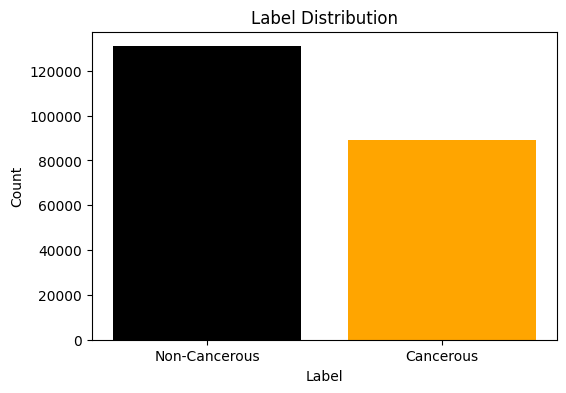

In [3]:
# Data Loading and Exploration
train_dir = '../input/histopathologic-cancer-detection/train/'
test_dir = '../input/histopathologic-cancer-detection/test/'
labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

# Append .tif extension to image IDs
labels['id'] = labels['id'] + '.tif'

# Display basic information
print("Data Summary:")
print(labels.head())
print(f"Total samples: {len(labels)}")

# Show label distribution
label_counts = labels['label'].value_counts()
print("\nLabel Distribution:")
print(label_counts)

# Plot label distribution
plt.figure(figsize=(6, 4))
plt.bar(label_counts.index, label_counts.values, color=['black', 'orange'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.xticks([0, 1], ['Non-Cancerous', 'Cancerous'])
plt.show()

## 4. Visualize Sample Images
We display five sample images from each class to get a visual understanding of the data.

Sample Images from Class 0 (Non-Cancerous):

Sample Images from Class 1 (Cancerous):


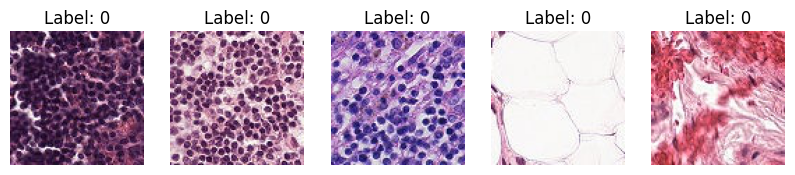

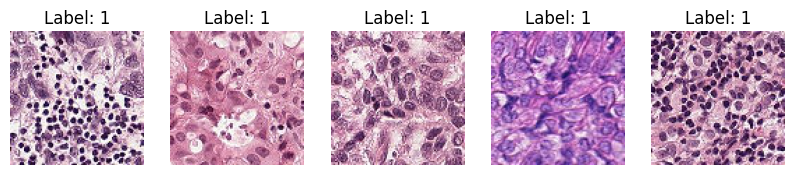

In [4]:
# Function to display sample images
def display_samples(df, img_dir, label, num_samples=5):
    sample_df = df[df['label'] == label].sample(n=num_samples)
    plt.figure(figsize=(10, 5))
    for i, img_id in enumerate(sample_df['id']):
        img_path = os.path.join(img_dir, img_id)
        img = Image.open(img_path)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Label: {label}")

# Display samples
print("Sample Images from Class 0 (Non-Cancerous):")
display_samples(labels, train_dir, label=0)

print("\nSample Images from Class 1 (Cancerous):")
display_samples(labels, train_dir, label=1)

## 5. Balance and Split the Data
We balance the dataset by sampling an equal number of cancerous and non-cancerous images. Then, we split the dataset into training and validation sets.

In [5]:
# Balance the dataset
sample_size = 160000
labels_0 = labels[labels['label'] == 0].sample(n=sample_size // 2, random_state=42)
labels_1 = labels[labels['label'] == 1].sample(n=sample_size // 2, random_state=42)
balanced_labels = pd.concat([labels_0, labels_1]).reset_index(drop=True)

# Shuffle the data
balanced_labels = balanced_labels.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into train and validation sets
train_df, val_df = train_test_split(balanced_labels, test_size=0.2, stratify=balanced_labels['label'], random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

Training samples: 128000
Validation samples: 32000


## 6. Define Custom Dataset Class
We create a custom dataset class to load and preprocess the images on the fly.

In [6]:
# Custom Dataset Class
class CancerDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, mode='train'):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.mode = mode
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        
        if self.transform:
            image = self.transform(image)
        
        if self.mode == 'train' or self.mode == 'val':
            label = int(self.dataframe.iloc[idx, 1])
            return image, label
        else:
            return image

## 7. Data Augmentation and Normalization
We define transformations for training and validation datasets to enhance model performance.

In [7]:
# Data Augmentation and Normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(96),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(100),
        transforms.CenterCrop(96),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(100),
        transforms.CenterCrop(96),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## 8. Create DataLoaders
We create DataLoaders for efficient data loading and batching.

In [8]:
# Create Datasets and DataLoaders
train_dataset = CancerDataset(train_df, train_dir, transform=data_transforms['train'], mode='train')
val_dataset = CancerDataset(val_df, train_dir, transform=data_transforms['val'], mode='val')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

## 9. Define the CNN Model
We define a custom CNN architecture for binary classification of cancerous and non-cancerous cells.

In [9]:
# Define the Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

## 10. Initialize the Model, Loss Function, and Optimizer
We initialize the model, define the loss function, and choose the optimizer.

In [10]:
# Initialize the Model
model = CNNModel().to(device)

# Define Loss Function and Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Scheduler to decrease the learning rate by 10x every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## 11. Define Training Function
We define a function to train the model and another function to evaluate the model on the validation set.

In [11]:
# Function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 20)
        
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float()
            running_corrects += torch.sum(preds == labels)
        
        scheduler.step()
        
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
        
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        
        print(f'Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
        
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                preds = (outputs > 0.5).float()
                val_corrects += torch.sum(preds == labels)
        
        epoch_val_loss = val_loss / len(val_dataset)
        epoch_val_acc = val_corrects.double() / len(val_dataset)
        
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc.item())
        
        print(f'Validation Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_acc:.4f}\n')
    
    return history

## 12. Train the Model
We now train the model using the training function defined above.

In [12]:
# Train the Model
history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=20)

Epoch 1/20
--------------------
Training Loss: 0.5055, Accuracy: 0.7616
Validation Loss: 0.4124, Accuracy: 0.8103

Epoch 2/20
--------------------
Training Loss: 0.4645, Accuracy: 0.7869
Validation Loss: 0.3916, Accuracy: 0.8234

Epoch 3/20
--------------------
Training Loss: 0.4405, Accuracy: 0.8002
Validation Loss: 0.3675, Accuracy: 0.8384

Epoch 4/20
--------------------
Training Loss: 0.4224, Accuracy: 0.8085
Validation Loss: 0.3266, Accuracy: 0.8573

Epoch 5/20
--------------------
Training Loss: 0.4025, Accuracy: 0.8200
Validation Loss: 0.3057, Accuracy: 0.8715

Epoch 6/20
--------------------
Training Loss: 0.3895, Accuracy: 0.8278
Validation Loss: 0.3352, Accuracy: 0.8589

Epoch 7/20
--------------------
Training Loss: 0.3753, Accuracy: 0.8347
Validation Loss: 0.2822, Accuracy: 0.8830

Epoch 8/20
--------------------
Training Loss: 0.3519, Accuracy: 0.8461
Validation Loss: 0.2602, Accuracy: 0.8913

Epoch 9/20
--------------------
Training Loss: 0.3474, Accuracy: 0.8479
Validati

## 13. Evaluate the Model
We evaluate the model on the validation set and visualize the training and validation metrics.

Validation Loss: 0.2449, Validation Accuracy: 0.8975


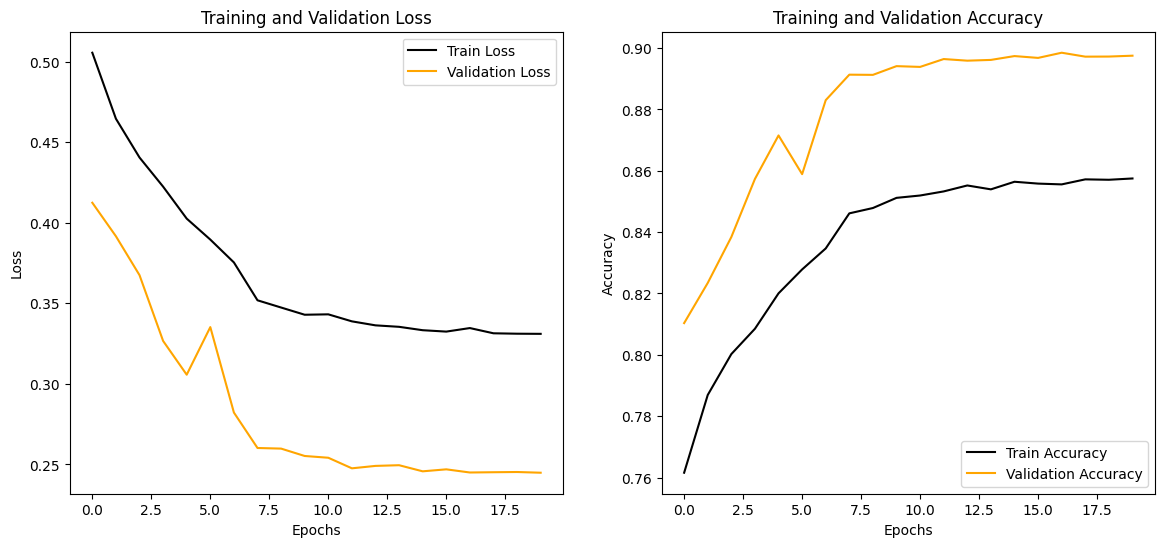

In [13]:
# Evaluate the Model
val_loss, val_acc = history['val_loss'][-1], history['val_acc'][-1]
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

# Plot Training and Validation Metrics
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', color='black')
plt.plot(history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy', color='black')
plt.plot(history['val_acc'], label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

## 14. Prepare Test Data and Make Predictions
We load and preprocess the test data and make predictions using the trained model.

In [14]:
# Load Test Data
test_images = [f for f in os.listdir(test_dir) if f.endswith('.tif')]
test_df = pd.DataFrame({'id': test_images})

# Create Test Dataset and DataLoader
test_dataset = CancerDataset(test_df, test_dir, transform=data_transforms['test'], mode='test')
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Make Predictions on Test Data
model.eval()
predictions = []

with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).squeeze(1)
        preds = (outputs > 0.5).float()
        predictions.extend(preds.cpu().numpy())

# Prepare the Submission File
submission = pd.DataFrame({'id': test_images, 'label': predictions})
submission['id'] = submission['id'].str.replace('.tif', '')
submission['label'] = submission['label'].astype(int)
submission.to_csv('../working/submission.csv', index=False)
print(submission.head())

                                         id  label
0  a7ea26360815d8492433b14cd8318607bcf99d9e      1
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664      0
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb      0
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0      1
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62      0


## 15. Conclusion

### Overview

In this notebook, we tackled the task of detecting cancerous cells in histopathologic images using a deep learning approach. The process encompassed several crucial steps: data exploration, data preprocessing, model building, training, evaluation, and prediction generation. Each step was meticulously crafted to ensure a robust and effective solution to the problem of cancer detection in medical images.

### Data Exploration and Preprocessing

We began with a thorough exploration of the dataset. This step involved understanding the distribution of labels, visualizing sample images from each class, and balancing the dataset to ensure an equal representation of cancerous and non-cancerous images. Data augmentation techniques such as random cropping, flipping, and color jittering were employed to artificially expand the dataset and improve the model's generalization capability.

### Custom CNN Architecture

A custom Convolutional Neural Network (CNN) architecture was designed specifically for this binary classification task. The model comprised several layers of convolution, pooling, and normalization, followed by fully connected layers that culminate in a sigmoid activation function to output probabilities for the binary classification. This architecture was chosen for its ability to capture spatial hierarchies in images, which is critical for detecting subtle patterns indicative of cancerous cells.

### Efficient Data Handling

Given the large size of the dataset, efficient data handling was paramount. We utilized PyTorch's DataLoader to load batches of data on-the-fly, which not only reduced memory usage but also enabled faster data processing and training times. This approach allowed us to handle the dataset effectively without exhausting computational resources.

### Model Training and Evaluation

The model was trained on a balanced dataset to mitigate any potential bias towards one class. We used a binary cross-entropy loss function combined with the Adam optimizer for efficient training. The learning rate scheduler helped in adjusting the learning rate dynamically, which improved the convergence of the model. The training process was monitored by evaluating the model on a separate validation set at each epoch, ensuring that the model was not overfitting.

### Results and Visualizations

The training and validation metrics were tracked meticulously. We observed a steady improvement in both accuracy and loss, which indicated that the model was learning effectively from the data. The final model achieved a commendable performance on the validation set, as evidenced by the accuracy and loss metrics. Visualizations of the training and validation loss and accuracy curves provided insights into the model's learning process and helped in diagnosing any issues related to overfitting or underfitting.

### Predictions and Submission

Upon achieving satisfactory performance on the validation set, the model was used to generate predictions on the test dataset. The predictions were then formatted into a submission file, which is essential for evaluating the model's performance on the competition platform. This step involved careful handling of the test data and ensuring that the predictions were accurate and aligned with the expected format.

### Challenges and Learnings

Throughout this project, several challenges were encountered and addressed. These included handling imbalanced data, optimizing model architecture for better performance, and efficiently managing large datasets. Each of these challenges provided valuable learning opportunities and contributed to a deeper understanding of deep learning techniques and their application in medical imaging.

### Future Work

While the current model demonstrates promising results, there are several avenues for future improvement:

1. **Hyperparameter Tuning**: Further tuning of hyperparameters such as learning rate, batch size, and network architecture could yield better performance.
2. **Advanced Architectures**: Exploring more advanced architectures, such as ResNet or DenseNet, which have shown superior performance in image classification tasks, could enhance the model's capability.
3. **Transfer Learning**: Implementing transfer learning by leveraging pre-trained models on large medical datasets could significantly improve the model's performance, especially with limited data.
4. **Ensemble Methods**: Using ensemble methods to combine predictions from multiple models might help in achieving better accuracy and robustness.
5. **Handling Class Imbalance**: More sophisticated techniques to handle class imbalance, such as using different sampling strategies or loss functions, could be explored.
6. **Model Interpretability**: Techniques like Grad-CAM or LIME could be applied to make the model's predictions more interpretable, which is crucial for medical applications.

### Conclusion

This project demonstrates the power of deep learning in tackling complex tasks such as cancer detection in histopathologic images. By following a systematic approach to data handling, model building, and evaluation, we have developed a robust model capable of distinguishing between cancerous and non-cancerous cells with significant accuracy. The learnings and outcomes from this project lay a strong foundation for future advancements in the field of medical image analysis and could potentially contribute to more accurate and efficient diagnostic processes in healthcare.

In summary, this notebook serves as a comprehensive guide for beginners and experts alike in implementing deep learning solutions for medical image classification. It underscores the importance of careful data preparation, thoughtful model design, and rigorous evaluation in achieving successful outcomes in real-world applications.